# Building and Training a Neural Network!
We have learned a bunch of modularized layers. It's time to put them all together, and train a NeuralNet to recognize the digits in MNIST. In this notebook we will walk you through training a simple three-layer NeuralNetwork and then set you free to build the best net that you can to perform well on MNIST dataset.

## Goal:

Open up the file `nnetwork.py`; you will see that the `three_layer_neuralnetwork` function computes the loss and gradients for a three-layer NeuralNetwork, your goal here is to complete the missing parts. Note that this function uses the "modular" layers defined in `layers.py`, you will have to complete that before proceeding with this assignment.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import the layers
from nnetwork import *
# As usual, a bit of setup
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Digit Recognition

We are going to build a three-layer neural network and use it for recognizing the digits. For this purpose we will be using the famous MNIST dataset.

 Note that the neural network parameters will be stored in a dictionary (`model` below), where the keys are the parameter names and the values are numpy arrays. Below, we initialize toy data and a toy model that we will use to verify your implementations.

Train data shape:  (50000L, 784L)
Train labels shape:  (50000L,)
Validation data shape:  (10000L, 784L)
Validation labels shape:  (10000L,)
Test data shape:  (10000L, 784L)
Test labels shape:  (10000L,)


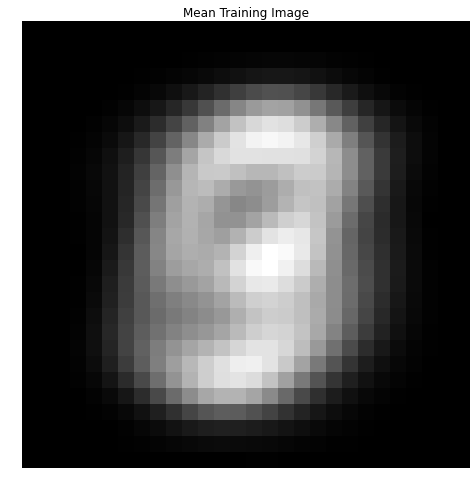

In [3]:
import mnist_loader as mnl
# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = mnl.get_mnist_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

# display the mean training image...
mean_train=np.mean(X_train,axis=0)
plt.imshow(mean_train.reshape(28,-1),cmap='gray')
plt.axis('off')
plt.title('Mean Training Image')

#
# Centralized the train, test, and validation data...
X_train=X_train-mean_train;
X_val=X_val-mean_train;
X_test=X_test-mean_train;


# Sanity check loss
Now we have all the ingredients in place. Now we are going to build a complete network. After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [4]:
#%pdb
#Initialize the weights
model = init_three_layer_neuralnet(weight_scale=0.01,input_feat_dim=32*32*3)

X = np.random.randn(1000, 3* 32* 32)
y = np.random.randint(10, size=1000)


# Compute the loss
loss, _ = three_layer_neuralnetwork(X, model, y, reg=0,verbose=1)

# Sanity check: Loss should be about log(10) = 2.3026, for a perfect random initalization of weights
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = three_layer_neuralnetwork(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

['Layer 1 Variance = 0.000200034590056', 'Layer 2 Variance = 2.15525838512e-08', 'Layer 3 Variance = 7.35341953742e-09']
Sanity check loss (no regularization):  2.30258513948
Sanity check loss (with regularization):  2.30849286332


# Gradient check
After the loss looks reasonable, you should always use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [5]:
from gradient_check import *

num_inputs = 3
feat_dim = 5
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, feat_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = init_three_layer_neuralnet(input_feat_dim=feat_dim)
import copy

mcopy=copy.deepcopy(model)

loss, grads = three_layer_neuralnetwork(X, model, y,verbose=1)

for param_name in sorted(grads):
    f = lambda _: three_layer_neuralnetwork(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    #print e
    print '%s max relative error: %e' % (param_name, e)

['Layer 1 Variance = 2.18852883633', 'Layer 2 Variance = 3.38955058375', 'Layer 3 Variance = 0.794160363111']
W1 max relative error: 2.263985e-07
W2 max relative error: 1.248766e-07
W3 max relative error: 2.938098e-06
b1 max relative error: 8.005930e-08
b2 max relative error: 5.242194e-09
b3 max relative error: 5.980053e-08


# Implementing Gradient Descent and Its Variants
To train the network we will use SGD with Momentum. Last assignment you implemented vanilla SGD. You will now implement the momentum update and the RMSProp update. Open the file `classifier_trainer.py` and familiarze yourself with the `ClassifierTrainer` class. It performs optimization given an arbitrary cost function data, and model. By default it uses vanilla SGD, which we have already implemented for you. First, run the optimization below using Vanilla SGD:

In [6]:
input_size = 4
num_classes = 3
num_inputs = 5

def init_toy_data():
  X = np.linspace(-0.2, 0.5, num=num_inputs*input_size).reshape(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

from classifier_trainer import ClassifierTrainer


X,y=init_toy_data()

#print "Input: ", X.shape
#print "labels: ",y.shape

model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)#returning nueral net model

trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.0, learning_rate_decay=1,
                                             update='sgd', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
print 'Final loss with vanilla SGD: %f' % (loss_history[-1], )

N:  5
Final loss with vanilla SGD: 0.447344


Now fill in the **momentum update** in tmuhe first missing code block inside the `train` function, and run the same optimization as above but with the momentum update. You should see a ch better result in the final obtained loss:

In [7]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print 'Final loss with Momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss)

N:  5
Final loss with Momentum SGD: 0.476309. We get: 0.046405


In [8]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='nestrov-momentum', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print 'Final loss with Nestrov-Momentum SGD: %f. We get: %f' % (loss_history[-1], correct_loss)

N:  5
Final loss with Nestrov-Momentum SGD: 0.282566. We get: 0.046405


Now also implement the **RMSProp** update rule inside the `train` function and rerun the optimization:

In [9]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='rmsprop', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print 'Final loss with RMSProp: %f. We get: %f' % (loss_history[-1], correct_loss)

N:  5
Final loss with RMSProp: 0.144823. We get: 0.046405


Now go and implement the (**`SMORMS3`**)[http://sifter.org/~simon/journal/20150420.html] update rule inside

In [10]:
model = init_three_layer_neuralnet(num_classes=num_classes,input_feat_dim=input_size)
trainer = ClassifierTrainer()
# call the trainer to optimize the loss
# Notice that we're using sample_batches=False, so we're performing Gradient Descent (no sampled batches of data)
best_model, loss_history, _, _ = trainer.train(X, y, X, y,
                                             model, three_layer_neuralnetwork,
                                             reg=0.001,
                                             learning_rate=1e-1, momentum=0.9, learning_rate_decay=1,
                                             update='SMORMS3', sample_batches=False,
                                             num_epochs=100,
                                             verbose=False)
correct_loss = 0.046405
print 'Final loss with SMORMS3: %f. We get: %f' % (loss_history[-1], correct_loss)

N:  5
Final loss with SMORMS3: 1.251001. We get: 0.046405


# Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

**Remember your model should start improving with in one to two epochs, if it is not improving then your initalization might be wrong. Print the variance across the layers to check whether your initalization is fine.**

In [11]:
#Finding data distribution...
print "Train distribution",np.bincount(y_train)
print "Validation distribution",np.bincount(y_val)
print "Test distribution",np.bincount(y_test)

Train distribution [4932 5678 4968 5101 4859 4506 4951 5175 4842 4988]
Validation distribution [ 991 1064  990 1030  983  915  967 1090 1009  961]
Test distribution [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [37]:
from classifier_trainer import *
trainer = ClassifierTrainer()
model=init_three_layer_neuralnet(weight_scale=1,input_feat_dim=X_train.shape[1],num_neurons=(10,10))
three_layer_neuralnetwork(X_train[:10000], model,y_train[:10000],0.001,verbose=1)
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train[:10000], y_train[:10000], X_val, y_val,
                                             model, three_layer_neuralnetwork,
                                             num_epochs=10, reg=0.01,batch_size=16,
                                             momentum=0.01, learning_rate_decay = 0.95,
                                             learning_rate=0.09,update='momentum', verbose=True)

['Layer 1 Variance = 0.131559658903', 'Layer 2 Variance = 0.172737662145', 'Layer 3 Variance = 0.0740608756484']
N:  10000
Finished epoch 0 / 10: cost 2.761902, train: 0.115000, val 0.123900, lr 9.000000e-02
Finished epoch 1 / 10: cost 0.450187, train: 0.892000, val 0.891300, lr 8.550000e-02
Finished epoch 2 / 10: cost 0.762332, train: 0.908000, val 0.897900, lr 8.122500e-02
Finished epoch 3 / 10: cost 0.398459, train: 0.927000, val 0.904500, lr 7.716375e-02
Finished epoch 4 / 10: cost 0.549461, train: 0.926000, val 0.909300, lr 7.330556e-02
Finished epoch 5 / 10: cost 0.379276, train: 0.926000, val 0.906600, lr 6.964028e-02
Finished epoch 6 / 10: cost 0.749657, train: 0.910000, val 0.906500, lr 6.615827e-02
Finished epoch 7 / 10: cost 0.465106, train: 0.926000, val 0.903600, lr 6.285036e-02
Finished epoch 8 / 10: cost 0.445714, train: 0.932000, val 0.909300, lr 5.970784e-02
Finished epoch 9 / 10: cost 0.756004, train: 0.937000, val 0.911500, lr 5.672245e-02
Finished epoch 10 / 10: cos

In [39]:
from vis_utils import visualize_grid
def show_net_weights_mnist(model,weights='W1'):
    plt.imshow(visualize_grid(model[weights].T.reshape(-1, 28, 28), padding=3,isgrayscale=True).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

### Plot the training loss evolution history

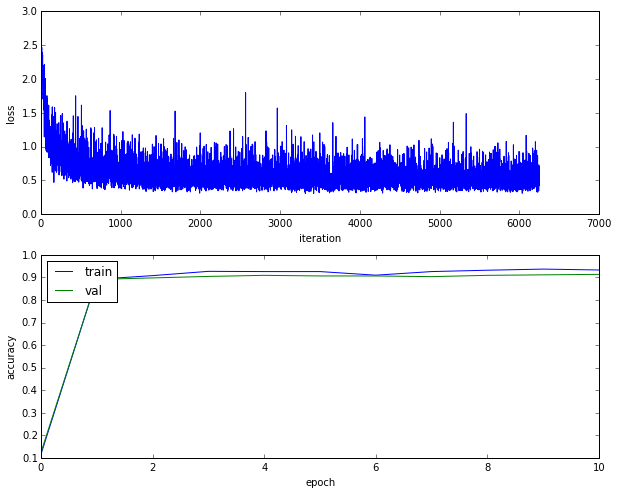

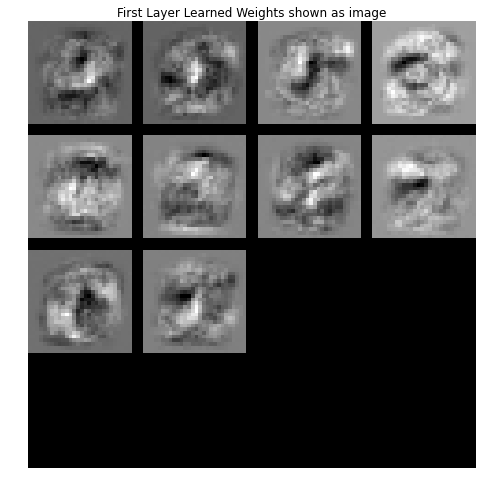

In [40]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
#print train_acc_history
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#Show the learned weights...
plt.title('First Layer Learned Weights shown as image')# they must look meaningful
show_net_weights_mnist(model)

# Train the net
Once the above works, training the net is the next thing to try. You can set the `acc_frequency` parameter to change the frequency at which the training and validation set accuracies are tested. If your parameters are set properly, you should see the training and validation accuracy start to improve within a hundred iterations, and you should be able to train a reasonable model with just one to five epochs.

Using the parameters below you should be able to get around 94% accuracy on the validation set.

In [41]:
#Initalizaing the Network
model=init_three_layer_neuralnet(weight_scale=1,input_feat_dim=X_train.shape[1],num_neurons=(60,40),num_classes=10);
#testing variance across the network they must be reasonable values, if the weights are initalized properly...
three_layer_neuralnetwork(X_train, model,y_train,0.001,verbose=1); 

['Layer 1 Variance = 0.135429766531', 'Layer 2 Variance = 0.147470745082', 'Layer 3 Variance = 0.050059276536']


In [59]:
#Training the Network
#rmsprop, nestrov-momentum,momentum
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(X_train, y_train, X_val, y_val,
                                             model, three_layer_neuralnetwork,
                                             num_epochs=18, reg=0.001,batch_size=64,
                                             momentum=0.5, learning_rate_decay = 0.95,
                                             learning_rate=1e-1,update='nestrov-momentum', verbose=True)

N:  50000
Finished epoch 0 / 17: cost 0.098245, train: 0.995000, val 0.980200, lr 1.000000e-01
Finished epoch 1 / 17: cost 0.107425, train: 0.995000, val 0.979200, lr 9.500000e-02
Finished epoch 2 / 17: cost 0.095621, train: 0.996000, val 0.979100, lr 9.025000e-02
Finished epoch 3 / 17: cost 0.126695, train: 0.998000, val 0.979200, lr 8.573750e-02
Finished epoch 4 / 17: cost 0.089477, train: 0.994000, val 0.979200, lr 8.145062e-02
Finished epoch 5 / 17: cost 0.100690, train: 0.996000, val 0.979700, lr 7.737809e-02
Finished epoch 6 / 17: cost 0.091755, train: 0.997000, val 0.979900, lr 7.350919e-02
Finished epoch 7 / 17: cost 0.100238, train: 0.997000, val 0.979100, lr 6.983373e-02
Finished epoch 8 / 17: cost 0.118427, train: 0.995000, val 0.979100, lr 6.634204e-02
Finished epoch 9 / 17: cost 0.102727, train: 0.997000, val 0.979600, lr 6.302494e-02
Finished epoch 10 / 17: cost 0.090373, train: 0.994000, val 0.979900, lr 5.987369e-02
Finished epoch 11 / 17: cost 0.129021, train: 0.992000

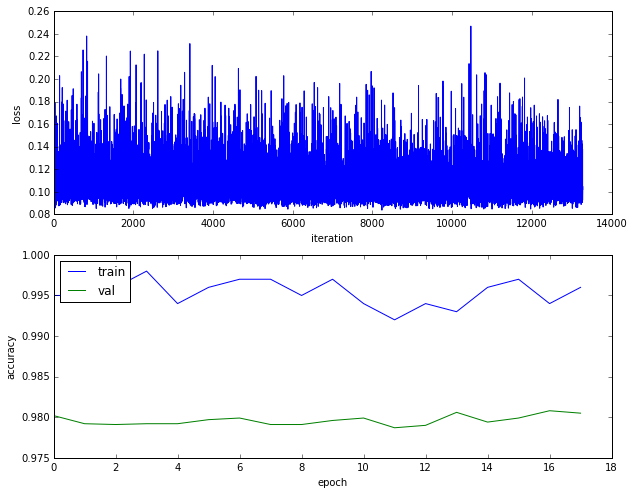

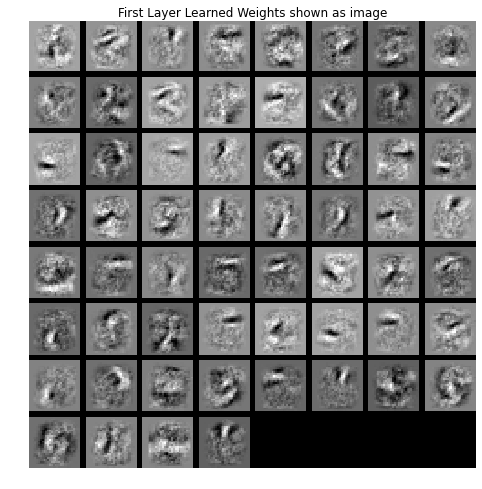

In [60]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
#print train_acc_history
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#Show the learned weights...
plt.title('First Layer Learned Weights shown as image')# they must look meaningful
show_net_weights_mnist(model)

# Testing the Network...
When you are done experimenting, you should evaluate your final trained network on the test set. 

**We will give you extra bonus point for every 1% of accuracy above 95%.**

**Remember You should only use test set once you have completed your experimentation. Try improving the performance on Validation Set not on the test set.**

In [61]:
scores_test = three_layer_neuralnetwork(X_test, model)
y_pred_test = np.argmax(scores_test, axis=1)
test_acc = np.mean(y_test == y_pred_test)
print ('Test Accuracy= {}'.format(test_acc))

Test Accuracy= 0.98


Predicted    0     1     2     3    4    5    6     7    8     9    All
Actual                                                                 
0          971     0     1     0    0    1    2     1    4     0    980
1            0  1126     2     1    0    1    3     0    2     0   1135
2            6     1  1010     2    1    0    3     6    3     0   1032
3            0     0     2   991    0    6    0     6    3     2   1010
4            1     0     3     1  959    0    3     2    0    13    982
5            2     0     0    10    0  868    3     1    5     3    892
6            5     3     1     1    7    3  934     0    4     0    958
7            1     7    10     3    0    0    0   999    1     7   1028
8            4     0     1     3    1    1    2     2  958     2    974
9            4     2     0     5    8    2    0     4    2   982   1009
All        994  1139  1030  1017  976  882  950  1021  982  1009  10000


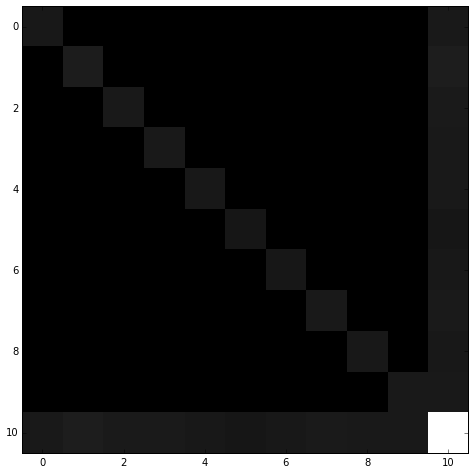

In [51]:
#Confusion Matrix Across classes...
from tools import print_confusion_matrix
df=print_confusion_matrix(y_pred_test,y_test)
print df
plt.imshow(df.as_matrix())

In [52]:
np.save('model-10-epochs-94',model)

# Your Turn

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. You might also consider tuning the momentum and learning rate decay parameters, but you should be able to get good performance using the default values.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 95% on the validation set. Our best network gets over 95% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on this dataset as you can, with a fully-connected Neural Network. For every 1% above 95% on the Test set we will award you with one extra bonus point. 